# [FMA: A Dataset For Music Analysis](https://github.com/mdeff/fma)

Michaël Defferrard, Kirell Benzi, Pierre Vandergheynst, Xavier Bresson, EPFL LTS2.

In [1]:
%matplotlib inline

import os

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import librosa
import librosa.display

import utils

plt.rcParams['figure.figsize'] = (17, 5)

In [2]:
# Directory where mp3 are stored.
AUDIO_DIR = os.environ.get('AUDIO_DIR')

# Load metadata and features.
tracks = utils.load('data/tracks.csv')
genres = utils.load('data/genres.csv')
features = utils.load('data/features.csv')
echonest = utils.load('data/echonest.csv')

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

tracks.shape, genres.shape, features.shape, echonest.shape

((106574, 52), (163, 4), (106574, 518), (13129, 249))

## 5 Genre classification

In [3]:
train = tracks['set', 'split'] == 'training'
val = tracks['set', 'split'] == 'validation'
test = tracks['set', 'split'] == 'test'

y_train = tracks.loc[train, ('track', 'genre_top')]
y_val = tracks.loc[val, ('track', 'genre_top')]
y_test = tracks.loc[test, ('track', 'genre_top')]

X_train = features.loc[train, 'mfcc']
X_val = features.loc[val, 'mfcc']
X_test = features.loc[test, 'mfcc']
print('{} training examples, {} testing examples'.format(y_train.size, y_test.size))
print('{} features, {} classes'.format(X_train.shape[1], np.unique(y_train.dropna()).size))

84353 training examples, 11263 testing examples
140 features, 16 classes


In [ ]:

train_mask = ~(X_train.isnull().any(axis=1) | y_train.isnull())
val_mask = ~(X_val.isnull().any(axis=1) | y_val.isnull())
test_mask = ~(X_test.isnull().any(axis=1) | y_test.isnull())

X_train_clean = X_train[train_mask]
y_train_clean = y_train[train_mask]
X_val_clean = X_val[val_mask]
y_val_clean = y_val[val_mask]
X_test_clean = X_test[test_mask]
y_test_clean = y_test[test_mask]

X_train_clean, y_train_clean = skl.utils.shuffle(X_train_clean, y_train_clean, random_state=42)

scaler = skl.preprocessing.StandardScaler(copy=True, with_mean=True, with_std=True)
X_train_scaled = scaler.fit_transform(X_train_clean)
X_val_scaled = scaler.transform(X_val_clean)
X_test_scaled = scaler.transform(X_test_clean)


In [ ]:
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

genres_to_keep = np.array(['Classical', 'Electronic', 'Hip-Hop', 'Jazz', 'Pop', 'Rock'])

train_mask_6 = train_mask & y_train_clean.isin(genres_to_keep)
val_mask_6 = val_mask & y_val_clean.isin(genres_to_keep) 
test_mask_6 = test_mask & y_test_clean.isin(genres_to_keep)

X_train_6 = X_train_clean[train_mask_6]
y_train_6 = y_train_clean[train_mask_6]
X_val_6 = X_val_clean[val_mask_6]
y_val_6 = y_val_clean[val_mask_6]
X_test_6 = X_test_clean[test_mask_6]
y_test_6 = y_test_clean[test_mask_6]


le = LabelEncoder()
le.fit(genres_to_keep) 
y_train_encoded = le.transform(y_train_6)
y_val_encoded = le.transform(y_val_6)
y_test_encoded = le.transform(y_test_6)


xgb_clf = xgb.XGBClassifier(
    learning_rate=0.1,
    max_depth=50,
    n_estimators=100,
    eval_metric='mlogloss',  
    random_state=42
)

class_counts = pd.Series(y_train_6).value_counts()
total_samples = len(y_train_6)
class_weights = {genre: float(total_samples / (len(genres_to_keep) * count + 1)) 
                for genre, count in class_counts.items()}

xgb_clf.set_params(scale_pos_weight=class_weights)
eval_set = [(X_val_6, y_val_encoded)]

xgb_clf = xgb.XGBClassifier(
    learning_rate=0.1,
    max_depth=5,
    n_estimators=100,
    random_state=42
)

xgb_clf.fit(
    X_train_6,
    y_train_encoded,
    eval_set=eval_set,
    verbose=False
)
val_score = xgb_clf.score(X_val_6, y_val_encoded)
print(f"Validation accuracy: {val_score:.3f}")  
best_model = xgb_clf

test_score = best_model.score(X_test_6, y_test_encoded)
print(f"\nTest accuracy: {test_score:.3f}")

print("\nClass Distribution:")
for genre, count in zip(genres_to_keep, np.bincount(y_train_encoded)):
    print(f"{genre}: {count}")


/tmp/ipykernel_1681/3504528233.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train_6 = X_train_clean[train_mask_6]
/tmp/ipykernel_1681/3504528233.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_val_6 = X_val_clean[val_mask_6]
/tmp/ipykernel_1681/3504528233.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_test_6 = X_test_clean[test_mask_6]


Validation accuracy: 0.736

Test accuracy: 0.782

Class Distribution:
Classical: 1069
Electronic: 7662
Hip-Hop: 2910
Jazz: 462
Pop: 1815
Rock: 11394


In [ ]:

print("\nClass Distribution in Training Set:")
print(class_counts)

print("\nClass Weights Being Used:")
print (genres_to_keep)
print(class_weights)



Class Distribution in Training Set:
(track, genre_top)
Rock                   11394
Electronic              7662
Hip-Hop                 2910
Pop                     1815
Classical               1069
Jazz                     462
Blues                      0
Country                    0
Easy Listening             0
Experimental               0
Folk                       0
Instrumental               0
International              0
Old-Time / Historic        0
Soul-RnB                   0
Spoken                     0
Name: count, dtype: int64

Class Weights Being Used:
['Classical' 'Electronic' 'Hip-Hop' 'Jazz' 'Pop' 'Rock']
{'Rock': 0.3702479338842975, 'Electronic': 0.5505840384573554, 'Hip-Hop': 1.4496306053490635, 'Pop': 2.324120833715912, 'Classical': 3.945752143413874, 'Jazz': 9.128020194734944, 'Blues': 25312.0, 'Country': 25312.0, 'Easy Listening': 25312.0, 'Experimental': 25312.0, 'Folk': 25312.0, 'Instrumental': 25312.0, 'International': 25312.0, 'Old-Time / Historic': 25312.0, '


Predicted genre: Electronic
Actual genre: Hip-Hop


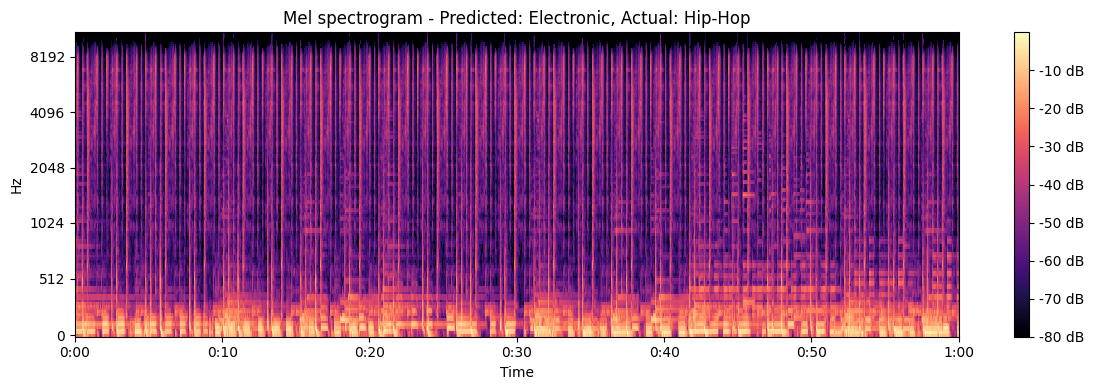

In [ ]:
import random
import os

small_tracks = tracks[tracks['set', 'subset'] <= 'small']
small_tracks = small_tracks[small_tracks['track', 'genre_top'].isin(genres_to_keep)]
small_track_ids = small_tracks.index.astype(str).str.zfill(6)

random_track_id = int(random.choice(small_track_ids))

mfcc_features = features.loc[random_track_id, 'mfcc'].values.reshape(1, -1)

mfcc_features_scaled = scaler.transform(mfcc_features)

# Get prediction from best model
prediction = best_model.predict(mfcc_features_scaled)
predicted_genre = le.inverse_transform(prediction)[0]

# Get actual genre
actual_genre = tracks.loc[random_track_id, ('track', 'genre_top')]

print(f"\nPredicted genre: {predicted_genre}")
print(f"Actual genre: {actual_genre}")

# Load and play the audio
folder = str(random_track_id).zfill(6)[:3]
file_path = os.path.join('data/small', folder, str(random_track_id).zfill(6) + '.mp3')
x, sr = librosa.load(file_path, sr=None, mono=True)

# Display the spectrogram
plt.figure(figsize=(12, 4))
mel = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=140)
librosa.display.specshow(librosa.power_to_db(mel, ref=np.max),
                        y_axis='mel', x_axis='time')
plt.title(f'Mel spectrogram - Predicted: {predicted_genre}, Actual: {actual_genre}')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

start, end = 0, 10  # Play first 10 seconds
ipd.Audio(data=x[start*sr:end*sr], rate=sr)
